# Twitter Sentiment Analysis
In this work, a dataset from twitter, which contains the text (tweets) of twitter users, other features and the sentiment (a label which may be neutral, negative or positive). The aim of this work is to obtain the best model that can be used to predict the sentiment of any tweet.

## Import Dependencies

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix

import keras
from keras import Sequential
from keras.layers import (
    TextVectorization,
    Dense,
    GlobalAveragePooling1D,
    Embedding,
    LSTM,
    Bidirectional
)
from keras.src.callbacks import EarlyStopping

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

2023-09-17 16:06:51.256123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading the data

In [5]:
data = pd.read_csv("../../datasets/tweets.csv")

## Exploratory Data Analysis

In [6]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [7]:
data.dtypes

textID               object
text                 object
selected_text        object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km�)     float64
Density (P/Km�)       int64
dtype: object

## Selecting The Required Columns
The columns of interest in this work are the tweets (text) and the sentiment assigned to them.

In [8]:
data = data[['text', 'sentiment']]
data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


## Creating a coded sentiment
Here, the sentiments, viz., negative, neutral and positive are represented by 0, 1 and 2.

## Checking for Any Missing Data or Empty String

In [9]:
def remove_empty_text(data_):
    for column in data_.columns:
        for row in data_.index:
            if data_.loc[row, column] == "":
                data_.drop(label=row, axis=0)
    return data_


In [231]:
missing_data = remove_empty_text(data)
missing_data

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [15]:
encoder = LabelEncoder()
# Here, 0 is negative, 1 is neutral and 2 is positive

# data['coded_sentiment'] = encoder.fit_transform(data.sentiment)
# data['coded_sentiment']
data['coded_sentiment'] = data['sentiment'].apply(
        lambda x: 
        0 if x == 'negative'
        else 1 if x == 'neutral'
        else 2
)

data['coded_sentiment']

0        1
1        0
2        0
3        0
4        0
        ..
27476    0
27477    0
27478    2
27479    2
27480    1
Name: coded_sentiment, Length: 27481, dtype: int64

## Grouping the Sentiments
Grouping the sentiments in other to find the number of words under each category.

sentiment
negative     7781
neutral     11117
positive     8582
Name: text, dtype: int64


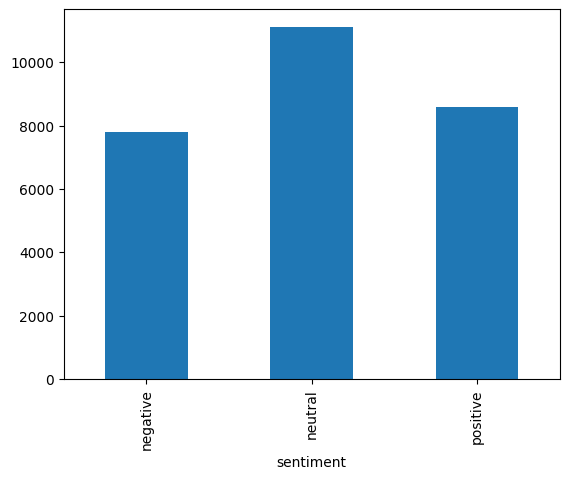

In [16]:
groups = data.groupby('sentiment').text.count()
print(groups)
groups.plot.bar(ylim=0)
plt.show()

## Making the Classes Equiprobable

In [18]:
min = groups.min()
random_state = 123
print('the minimum class size is =', min)

data_negative = data[data['sentiment'] == 'negative'].sample(min, random_state=random_state)
data_neutral = data[data['sentiment'] == 'neutral'].sample(min, random_state=random_state)
data_positive = data[data['sentiment'] == 'positive'].sample(min, random_state=random_state)

the minimum class size is = 7781


In [19]:
# Data points with negative sentiments only
data_negative

,text,sentiment,coded_sentiment
15351,' ...not academically of course. ' I miss him ...,negative,0
25133,come back to Perth I missed the show here!,negative,0
16324,it would hurt only when you touch it or when ...,negative,0
20751,Just dusted & vacuumed apartment. I think I n...,negative,0
25771,Just found out my parents are putting down my ...,negative,0
...,...,...,...
14485,you didn`t come to see the hosts at hilton mr...,negative,0
4877,I`m always a little sad to see followers I rea...,negative,0
12229,daaammmnnnnn I do wish I was there.,negative,0
26565,being sunburnt is horrible,negative,0


In [20]:
# Data points with postive sentiments only
data_positive

,text,sentiment,coded_sentiment
26511,Just chillin at home,positive,2
6868,Been meaning to email you for months. Your pr...,positive,2
15754,_04071991 haaa awesome! i remember my brother ...,positive,2
14899,Hi Serena just want to say good luck in Madri...,positive,2
27068,"No, i dont think its bad. And its very well e...",positive,2
...,...,...,...
7490,shouldn`t have stayed up til almost 2 reading ...,positive,2
8990,I just arrived in the office.. I am preparing ...,positive,2
13721,R-T 30 Cool Things For Successful Entrepreneu...,positive,2
5582,Alternate name for a 'Bacon Mary'... A 'Blood...,positive,2


In [21]:
# Data points with neutral sentiments only
data_neutral

,text,sentiment,coded_sentiment
18506,_Devil1 Big Brother quiz? What?! I`m too bus...,neutral,1
24,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral,1
1656,Hence the smiley face. ha ha ha ha. Lol yeah ...,neutral,1
2258,found out that no one he knows is using Twitter.,neutral,1
4865,I will try. But I don`t care what my mum says,neutral,1
...,...,...,...
3673,morning to you too joe,neutral,1
26405,Craziier are off of msn!,neutral,1
22407,White wine reminds me of vinegar,neutral,1
1226,Oh yes..i think almost every Tuesday in June....,neutral,1


In [23]:
# The combined dataset with equiprobable classes
data = pd.concat([data_negative, data_positive, data_neutral]).sample(min)
data

,text,sentiment,coded_sentiment
12784,food...food...FOOD!,neutral,1
6980,Why don`t adobe realise no one WANTS to pay fo...,neutral,1
20300,"And these poor, unfortunate souls don`t appea...",negative,0
7396,sounds like my town,neutral,1
19554,Back in SJ. Star Trek tonight at 9:45pm at Cin...,neutral,1
...,...,...,...
11086,Come on guys tell me how much your theater cha...,neutral,1
4609,6789998212 haha love soulja boys new song,positive,2
26101,More than welcome...would love to do more phy...,neutral,1
26336,Is Charleston bound for the day,neutral,1


## Visualizing the Data again

sentiment
negative    2621
neutral     2585
positive    2575
Name: text, dtype: int64


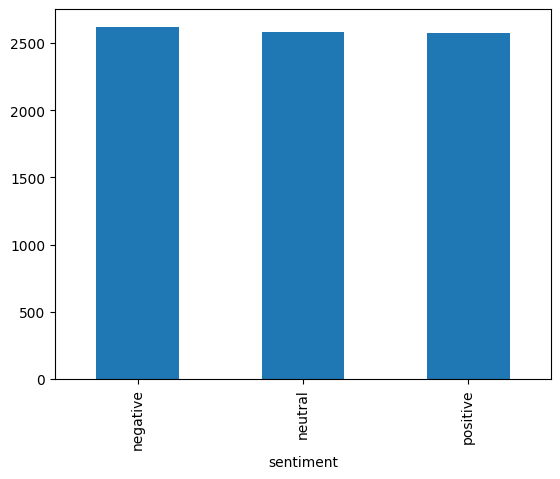

In [24]:
groups = data.groupby('sentiment').text.count()
print(groups)
groups.plot.bar(ylim=0)
plt.show()

## Classes of Sentiments
Here, 0 is negative, 1 is neutral and 2 is positive

In [25]:
classes = ["negative", "neutral", "positive"]

## Cleaning the Text Data

In [26]:
def clean_data(entity, text_column_name=None, label_column_name=None):
    lemma = WordNetLemmatizer()
    stemmer = PorterStemmer()
    stop_words = stopwords.words("english")

    if type(entity) == pd.pandas.core.frame.DataFrame:
        data_frame = entity

        # dealing with the text (tweets) column
        text_ = text_column_name
        data_frame[text_] = data_frame[text_].apply(
            lambda statement: ' '.join(word.lower() for word in str(statement).split())
        )  # making the words lowercase
        data_frame[text_] = data_frame[text_].apply(
            lambda statement: ' '.join(word for word in str(statement).split() if word not in stop_words)
        )  # removing stopwords
        data_frame[text_] = data_frame[text_].apply(
            lambda statement: ' '.join(stemmer.stem(word) for word in str(statement).split())
        )
        data_frame[text_] = data_frame[text_].apply(
            lambda statement: ' '.join(lemma.lemmatize(word=word) for word in str(statement).split())
        )  # lemmatizing

        # dealing with the label (sentiment) column
        label_ = label_column_name
        encoder = LabelEncoder()
        data[label_] = encoder.fit_transform(data[label_])

        return data_frame

    elif type(entity) == list and text_column_name is None and label_column_name is None:
        list_ = entity[0]
        list_ = list(map(lambda statement: ' '.join(word.lower() for word in str(statement).split()), list_))  # making the words lowercase
        list_ = list(map(lambda statement: ' '.join(word for word in str(statement).split() if word not in stop_words), list_))  # removing stopwords
        list_ = list(map(lambda statement: ' '.join(stemmer.stem(word) for word in str(statement).split()), list_))
        list_ = list(map(lambda statement: ' '.join(lemma.lemmatize(word=word) for word in str(statement).split()), list_)) # lemmatizing

        return [list_]
    else:
        raise Exception('The supplied entity must be a list or a dataframe')


## Obtaining the correct training data

In [27]:
cleaned_data = clean_data(data, text_column_name='text', label_column_name='sentiment')
text = cleaned_data['text']
label = cleaned_data['sentiment']

## Splitting the Data into Train and Test Sets

In [28]:
train_text, test_text, train_label, test_label = train_test_split(text, label, test_size=20, random_state=123)

## Converting Text to Vector

In [29]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=None)
vectorizer.fit(train_text)
train_data = vectorizer.transform(train_text)
test_data = vectorizer.transform(test_text)

# viewing the vector into which the train data was transofrmed
print(train_data[0])

  (0, 9932)	0.363317940257939
  (0, 9729)	0.4198821783921516
  (0, 9364)	0.43633064538322386
  (0, 6505)	0.29668803555552153
  (0, 4610)	0.46058921779072265
  (0, 3786)	0.4484956861197053


## Some Text of Interest for which to Find Sentiments 

In [30]:
# Non-Negative Statements
t1 = [["i like what he is doing, he is doing great"]]
t2 = [["I gave birth to a set of twins today"]]
t3 = [["you are now changed for the better thank God!!!"]]
t4 = [["I am leaving for Lagos tomorrow. Come with me"]]

# Negative Statements
n1 = [["We never loved him. We hated him instead he is an idiot"]]
n2 = [["Those foolish men took me for an idiot but I hated them much more than their craze!!!"]]
n3 = [["I will rather kill him, than have him for a friend."]]
n4 = [["I know a film industry that failed because its"
        + "films were full horrors and a lot of bloodshed, war and disaster - it a weak industry. "]]

# All statements put together in a list
statements = [n1, n2, n3, n4, t1, t2, t3, t4]
item_names = ['n1', 'n2', 'n3', 'n4', 't1', 't2', 't3', 't4']

## A Function for Printing the Results from Traditional ML 

In [31]:
def model_result(estimator, x_train, y_train, x_test, y_test, show_confusion_matrix=False):
    """
    Fits the supplied model (estimator) using the train dataset and obtains the validation and test accuracies.
    :param show_confusion_matrix: whether a confusion matrix should be displayed - it is displayed if True.
    :param estimator: the estimator to be used to fit the model.
    :param x_train: the train dataset containing only the features.
    :param y_train: the train dataset containing only the labels.
    :param x_test: the test dataset containing only the features
    :param y_test: the test dataset containing only the labels.
    :return: a dictionary containing the estimator, validation accuracy and test accuracy.
    """
    estimator.fit(x_train, y_train)
    validation_accuracy_ = cross_val_score(estimator, x_train, y_train, cv=5).mean().round(decimals=4)
    test_accuracy_ = estimator.score(x_test, y_test)
    predicted_y = estimator.predict(x_test)
    confusion_matrix_ = np.int64(confusion_matrix(y_test, predicted_y))
    pickle.dump(estimator, open('../../models/'+str(estimator)[0:8]+".pickle", 'wb'))

    if show_confusion_matrix:
        coded_sentiment_df = data[['sentiment', 'coded_sentiment']].drop_duplicates().sort_values('coded_sentiment')
        # print(coded_sentiment)
        cs_dict = dict(coded_sentiment_df.values)  # cs is short for coded_sentiment

        sns.heatmap(confusion_matrix_,
                    annot=True,
                    fmt='d',
                    cmap="spring",
                    xticklabels=coded_sentiment_df['sentiment'].values,
                    yticklabels=coded_sentiment_df['sentiment'].values
                    )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix of predicted and Actual Classes')
        plt.show()

    print(confusion_matrix_)
    return {'estimator': estimator,
            'validation_accuracy': validation_accuracy_,
            'test_accuracy': test_accuracy_,
            'confusion_matrix': confusion_matrix_}


## Naive Bayes

## Searching for the Best Naive Bayes Model

In [32]:
nb_clf = MultinomialNB()
param_grid = dict(alpha=[0, 0.4, 0.6, 0.8, 1], force_alpha=[True])
grid_search = GridSearchCV(nb_clf, param_grid=param_grid)
grid_search.fit(train_data, train_label)
best_estimator = grid_search.best_estimator_ 
print('best_estimator =', best_estimator)

/Users/user/PycharmProjects/textProcessing/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/user/PycharmProjects/textProcessing/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/user/PycharmProjects/textProcessing/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/user/PycharmProjects/textProcessing/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/user/PycharmProjects/textProcessing/venv/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in l

best_estimator = MultinomialNB(alpha=1, force_alpha=True)


## The Best Naive Bayes Model

In [33]:
nb_clf = MultinomialNB(alpha=0.6, force_alpha=True)
knn_result = model_result(nb_clf, train_data, train_label, test_data, test_label)
knn_result

[[5 1 0]
 [3 4 1]
 [1 1 4]]


{'estimator': MultinomialNB(alpha=0.6, force_alpha=True),
 'validation_accuracy': 0.6168,
 'test_accuracy': 0.65,
 'confusion_matrix': array([[5, 1, 0],
        [3, 4, 1],
        [1, 1, 4]])}

## K-Nearest Neighbours Model

### Searching for the Best K-Nearest Neighbours Model

In [34]:
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(3, 20, 2))}
grid_search = GridSearchCV(knn_clf, param_grid=param_grid)
grid_search.fit(train_data, train_label)
best_estimator = grid_search.best_estimator_
print('best_estimator =', best_estimator)

best_estimator = KNeighborsClassifier(n_neighbors=19)


### The Best K-Nearest Neighbours Model

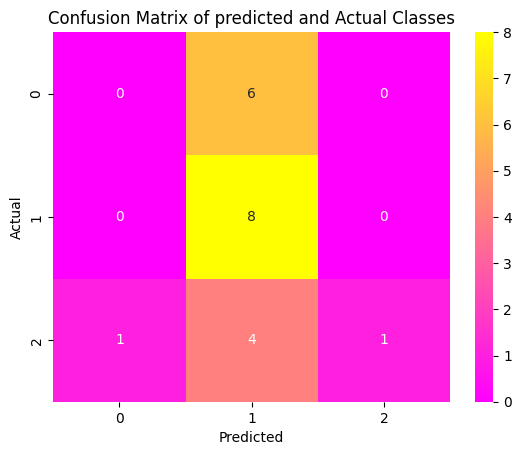

[[0 6 0]
 [0 8 0]
 [1 4 1]]
{'estimator': KNeighborsClassifier(n_neighbors=3), 'validation_accuracy': 0.3734, 'test_accuracy': 0.45, 'confusion_matrix': array([[0, 6, 0],
       [0, 8, 0],
       [1, 4, 1]])}


In [36]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_result = model_result(knn_clf, train_data, train_label, test_data, test_label, show_confusion_matrix=True)
print(knn_result)

## Decision Tree

### Searching for the Best Decision Tree Model

In [37]:
dt_clf = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'log_loss'],
    'max_depth': [200],
    'min_samples_split': [50],
    'min_samples_leaf': [50],
    'max_leaf_nodes': [50],
}  
grid_search = GridSearchCV(dt_clf, param_grid=param_grid)
grid_search.fit(train_data, train_label)
best_estimator = grid_search.best_estimator_
print('best_estimator =', grid_search.best_estimator_)

best_estimator = DecisionTreeClassifier(criterion='log_loss', max_depth=200, max_leaf_nodes=50,
                       min_samples_leaf=50, min_samples_split=50)


### The Best Decision Tree Model

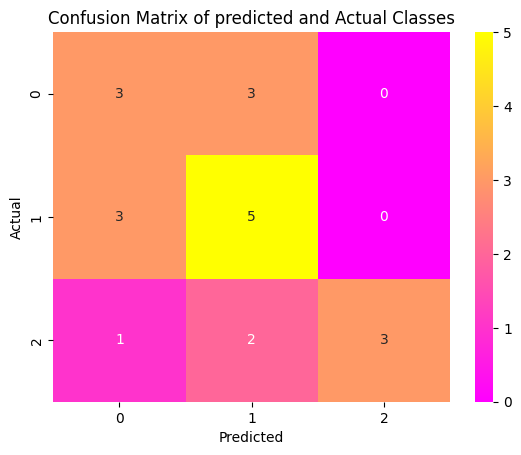

[[3 3 0]
 [3 5 0]
 [1 2 3]]
{'estimator': DecisionTreeClassifier(criterion='log_loss', max_depth=200, max_leaf_nodes=50,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=123), 'validation_accuracy': 0.5602, 'test_accuracy': 0.55, 'confusion_matrix': array([[3, 3, 0],
       [3, 5, 0],
       [1, 2, 3]])}


In [38]:
dt_clf = DecisionTreeClassifier(
    criterion='log_loss',
    max_depth=200,
    min_samples_split=50,
    min_samples_leaf=50,
    max_leaf_nodes=50,
    random_state=123
)
dt_result = model_result(dt_clf, train_data, train_label, test_data, test_label, show_confusion_matrix=True)
print(dt_result)


## Random Forest Model

### Searching for the Best Random Forest Model

In [39]:
rf_clf = RandomForestClassifier()
param_grid = {
    'criterion': ['gini', 'log_loss'],
    'max_depth': range(200, 500, 100),
    'min_samples_split': [20],
    'min_samples_leaf': [20],
    'max_leaf_nodes': [20],
}
grid_search = GridSearchCV(rf_clf, param_grid=param_grid)
rf_clf.fit(train_data, train_label)
grid_search.fit(train_data, train_label)
best_estimator = grid_search.best_estimator_
print('best_estimator =', grid_search.best_estimator_)

best_estimator = RandomForestClassifier(criterion='log_loss', max_depth=400, max_leaf_nodes=20,
                       min_samples_leaf=20, min_samples_split=20)


### The Best Random Forest Model

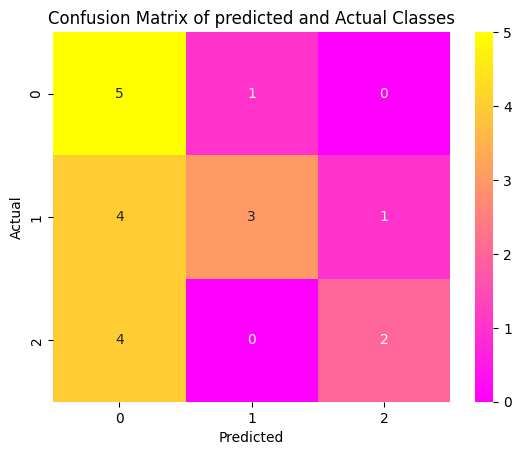

[[5 1 0]
 [4 3 1]
 [4 0 2]]
{'estimator': RandomForestClassifier(max_depth=200, max_leaf_nodes=50, min_samples_leaf=50,
                       min_samples_split=50, random_state=123), 'validation_accuracy': 0.4898, 'test_accuracy': 0.5, 'confusion_matrix': array([[5, 1, 0],
       [4, 3, 1],
       [4, 0, 2]])}


In [40]:
rf_clf = RandomForestClassifier(
    criterion='gini',
    max_depth=200,
    min_samples_split=50,
    min_samples_leaf=50,
    max_leaf_nodes=50,
    random_state=123
)
rf_result = model_result(rf_clf, train_data, train_label, test_data, test_label, show_confusion_matrix=True)
print(rf_result)

## Neural Network

### Some Constants

In [41]:
vocab_size = 80000
max_len = 250

### Putting all the Rows of the Column _text_ into a List

In [42]:
text = " ".join(x for x in train_text)
print("len_text", len(text))

len_text 369050


### The Layer that Converts the Words to Integers and Builds the Vocabulary

In [44]:
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_len
)

# learning from the original text, in order to convert each word to an integer
vectorize_layer.adapt([train_text])

# converter will be used to convert text to a vector of integers
converter = Sequential()
converter.add(vectorize_layer)

### To Convert Trained Data to Integers for Use in Building the Model

In [45]:
train_data = converter.predict(train_text)  # The train_text is then converted to integer
test_data = converter.predict(test_text)  # The test_text is then converted to integer
# print("train_tensor", train_data[1])
vocab = vectorize_layer.get_vocabulary()
print(vocab[50])
print(train_data[300])

1/1 [==============================] - 0s 22ms/step
would
[10195   194   171   630  7418     5  1966  5551  2291  4398   302   456
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0

### Testing the Converter

In [46]:
test = converter.predict(clean_data([["I like this this this thing, like"]]))
print("text", test)

1/1 [==============================] - 0s 107ms/step
text [[10 61 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]]


### Building the Model
Two types of neural network models will be used, viz. the Convolutional Neural Network and the Recurrrent Neural Network. The early stop technique will be used for both types of network to prevent overfitting.

In [91]:
def create_model(x_train, y_train, model_type='cnn'):
    model_ = Sequential()
    if model_type == 'cnn':
        model_ = Sequential([
            Embedding(input_dim=vocab_size, output_dim=200),
            GlobalAveragePooling1D(),
            Dense(units=100, activation='relu'),
            Dense(units=3, activation="softmax")
        ])
        # model_.summary()
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
        model_.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
        model_.fit(x_train, y_train, epochs=10, batch_size=20, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

        # saving the model
        model_.save('../../models/cnn_model.keras')
        
        return model_

    elif model_type == 'rnn':
        model_ = Sequential([
            Embedding(input_dim=vocab_size, output_dim=200),
            Bidirectional(LSTM(200, return_sequences=False)),
            Dense(units=100, activation='relu'),
            Dense(units=3, activation="softmax")
        ])
    
        # model_.summary()
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=1)
        model_.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
        model_.fit(x_train, y_train, epochs=10, batch_size=200, validation_split=0.2, shuffle=True, callbacks=[early_stopping])
    
        # saving the model
        model_.save('../../models/rnn_model.keras')

        return model_

    else:
        raise Exception("model_type can only take a value of ['cnn', 'rnn']")

    


### Evaluating the Neural Network Model

In [82]:

def dp_model_result(f_model, x_test, y_test, show_confusion_matrix=False):
    """ Computes the test accuracy, and confusion matrix for an already fitted deep learning model.
    :param f_model: an already fitted neural network model.
    :param x_test: the test dataset containing only the feature(s).
    :param y_test: the test dataset containing only the labels.
    :return: a dictionary of the estimator, test accuracy and confusion matrix.
    """
    test_accuracy = np.array(f_model.evaluate(x_test, y_test)).round(decimals=4)
    predicted_probabilities = f_model.predict(x_test)
    predictions = []

    for probability in predicted_probabilities:
        predictions.append(np.argmax(probability))

    predicted_y = np.array(predictions)
    confusion_matrix_ = confusion_matrix(y_test, predicted_y)
    
    if show_confusion_matrix:
        coded_sentiment_df = data[['sentiment', 'coded_sentiment']].drop_duplicates().sort_values('coded_sentiment')
        # print(coded_sentiment)
        cs_dict = dict(coded_sentiment_df.values)  # cs is short for coded_sentiment
    
        sns.heatmap(confusion_matrix_,
                    annot=True,
                    fmt='d',
                    cmap="spring",
                    xticklabels=coded_sentiment_df['sentiment'].values,
                    yticklabels=coded_sentiment_df['sentiment'].values
                    )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix of predicted and Actual Classes')
        plt.show()
    
    return {'test_accuracy': test_accuracy, 'confusion_matrix': confusion_matrix_}


## Convolution Neural Network (CNN)

In [83]:
# executing create_model for cnn
cnn_model = create_model(train_data, train_label)

# Loading the saved Model
cnn_model = keras.models.load_model('../../models/cnn_model.keras')

Epoch 1/10
311/311 [==============================] - 61s 192ms/step - loss: 1.0989 - accuracy: 0.3447 - val_loss: 1.0985 - val_accuracy: 0.3278
Epoch 2/10
311/311 [==============================] - 60s 192ms/step - loss: 1.0968 - accuracy: 0.3571 - val_loss: 1.0941 - val_accuracy: 0.3419
Epoch 3/10
311/311 [==============================] - 65s 209ms/step - loss: 1.0597 - accuracy: 0.4396 - val_loss: 1.0010 - val_accuracy: 0.5744
Epoch 4/10
311/311 [==============================] - 78s 251ms/step - loss: 0.8594 - accuracy: 0.6071 - val_loss: 0.8857 - val_accuracy: 0.5589
Epoch 5/10
311/311 [==============================] - 65s 209ms/step - loss: 0.7156 - accuracy: 0.6904 - val_loss: 0.9193 - val_accuracy: 0.5924
Epoch 6/10
311/311 [==============================] - 71s 230ms/step - loss: 0.6277 - accuracy: 0.7532 - val_loss: 0.8963 - val_accuracy: 0.6188
Epoch 7/10
311/311 [==============================] - 67s 214ms/step - loss: 0.5550 - accuracy: 0.7856 - val_loss: 0.8635 - val_ac

### CNN Result

1/1 [==============================] - 0s 66ms/step


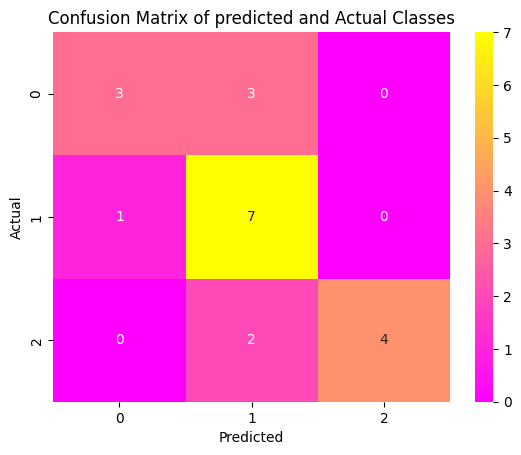

{'test_accuracy': array([0.4683, 0.7   ]), 'confusion_matrix': array([[3, 3, 0],
       [1, 7, 0],
       [0, 2, 4]])}


In [84]:
cnn_result = dp_model_result(cnn_model, test_data, test_label, show_confusion_matrix=True)
print(cnn_result)

### Making Prediction Using the CNN Model

#### a. Break Down of Predictions
Presenting a break down of how prediction works

In [85]:
l = ["I am glad today i am now a millionaire."]
clean_dat = clean_data([l])
print('the vector of integers for l =', l, 'is as shown below:')

converted_dat = converter.predict(clean_dat)
print(converted_dat)

test1 = cnn_model.predict(converted_dat)
print('the predicted probabilities of sentiment are:', test1)
print('the predicted class is:', classes[np.argmax(test1)])

the vector of integers for l = ['I am glad today i am now a millionaire.'] is as shown below:
1/1 [==============================] - 0s 44ms/step
[[218  13   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   

#### b. Other Predictions
Now other predictions to show what the model actually does to supplied text

In [86]:
# converting the Non-negative Statements to Vectors of Integers
t1_c = cnn_model.predict(converter.predict(clean_data(t1)))
t2_c = cnn_model.predict(converter.predict(clean_data(t2)))
t3_c = cnn_model.predict(converter.predict(clean_data(t3)))
t4_c = cnn_model.predict(converter.predict(clean_data(t4)))

# Converting the Negative Statements to Vectors of integers
n1_c = cnn_model.predict(converter.predict(clean_data(n1)))
n2_c = cnn_model.predict(converter.predict(clean_data(n2)))
n3_c = cnn_model.predict(converter.predict(clean_data(n3)))
n4_c = cnn_model.predict(converter.predict(clean_data(n4)))

print('\nPrediction Results:')
i = 0
for prob_array in [n1_c, n2_c, n3_c, n4_c, t1_c, t2_c, t3_c, t4_c]:
    print(item_names[i], '=', statements[i][0], 'is', classes[np.argmax(prob_array)])
    i += 1

1/1 [==============================] - 0s 26ms/step

Prediction Results:
n1 = ['We never loved him. We hated him instead he is an idiot'] is neutral
n2 = ['Those foolish men took me for an idiot but I hated them much more than their craze!!!'] is negative
n3 = ['I will rather kill him, than have him for a friend.'] is negative
n4 = ['I know a film industry that failed because itsfilms were full horrors and a lot of bloodshed, war and disaster - it a weak industry. '] is negative
t1 = ['i like what he is doing, he is doing great'] is positive
t2 = ['I gave birth to a set of twins today'] is positive
t3 = ['you are now changed for the better thank God!!!'] is positive
t4 = ['I am leaving for Lagos tomorrow. Come with me'] is neutral


## Recurrent Neural Network (RNN)

In [92]:
# executing create_model for rnn
model = create_model(train_data, train_label, model_type='rnn')

# Loading the saved model
rnn_model = keras.models.load_model('../../models/rnn_model.keras')

Epoch 1/10
32/32 [==============================] - 124s 4s/step - loss: 1.0561 - accuracy: 0.4393 - val_loss: 1.1001 - val_accuracy: 0.4346
Epoch 2/10
32/32 [==============================] - 4089s 132s/step - loss: 0.7634 - accuracy: 0.6603 - val_loss: 0.8481 - val_accuracy: 0.6072
Epoch 3/10
32/32 [==============================] - 120s 4s/step - loss: 0.5002 - accuracy: 0.8049 - val_loss: 0.9186 - val_accuracy: 0.6375
Epoch 4/10
32/32 [==============================] - 118s 4s/step - loss: 0.2974 - accuracy: 0.8971 - val_loss: 1.0881 - val_accuracy: 0.6233


### RNN Result

1/1 [==============================] - 1s 938ms/step


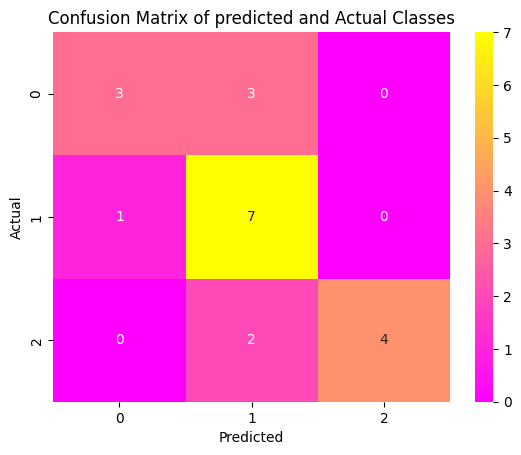

{'test_accuracy': array([0.6789, 0.7   ]), 'confusion_matrix': array([[3, 3, 0],
       [1, 7, 0],
       [0, 2, 4]])}


In [88]:
rnn_result = dp_model_result(model, test_data, test_label, show_confusion_matrix=True)
print(rnn_result)

### Making Prediction Using the RNN Model

#### a. Break Down of Predictions
Presenting a break down of how prediction works

In [89]:
l = ["I am glad today i am now a millionaire."]
clean_dat = clean_data([l])
print('the vector of integers for l =', l, 'is as shown below:')

converted_dat = converter.predict(clean_dat)
print(converted_dat)

test1 = model.predict(converted_dat)
print('the predicted probabilities of sentiment are:', test1)
print('the predicted class is:', classes[np.argmax(test1)])

the vector of integers for l = ['I am glad today i am now a millionaire.'] is as shown below:
1/1 [==============================] - 0s 45ms/step
[[218  13   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   

#### b. Other Predictions
Now other predictions to show what the model actually does to supplied text

In [90]:
# converting the Non-negative Statements to Vectors of Integers
t1_r = rnn_model.predict(converter.predict(clean_data(t1)))
t2_r = rnn_model.predict(converter.predict(clean_data(t2)))
t3_r = rnn_model.predict(converter.predict(clean_data(t3)))
t4_r = rnn_model.predict(converter.predict(clean_data(t4)))

# Converting the Negative Statements to Vectors of integers
n1_r = rnn_model.predict(converter.predict(clean_data(n1)))
n2_r = rnn_model.predict(converter.predict(clean_data(n2)))
n3_r = rnn_model.predict(converter.predict(clean_data(n3)))
n4_r = rnn_model.predict(converter.predict(clean_data(n4)))

print('\nPrediction Results:')
i = 0
for prob_array in [n1_r, n2_r, n3_r, n4_r, t1_r, t2_r, t3_r, t4_r]:
    print(item_names[i], '=', statements[i][0], 'is', classes[np.argmax(prob_array)])
    i += 1

1/1 [==============================] - 0s 64ms/step

Prediction Results:
n1 = ['We never loved him. We hated him instead he is an idiot'] is negative
n2 = ['Those foolish men took me for an idiot but I hated them much more than their craze!!!'] is negative
n3 = ['I will rather kill him, than have him for a friend.'] is negative
n4 = ['I know a film industry that failed because itsfilms were full horrors and a lot of bloodshed, war and disaster - it a weak industry. '] is neutral
t1 = ['i like what he is doing, he is doing great'] is positive
t2 = ['I gave birth to a set of twins today'] is positive
t3 = ['you are now changed for the better thank God!!!'] is positive
t4 = ['I am leaving for Lagos tomorrow. Come with me'] is neutral
